In [35]:
import os
import wfdb
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.models as models
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.metrics import f1_score
import torch.nn.functional as F
import numpy as np

In [6]:
class ECGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: 데이터셋의 루트 디렉토리 (예: 'D:/mimiciv_data/mimic-iv-ecg/1.0/preprocessed')
        transform: 데이터에 적용할 변환
        """
        self.root_dir = root_dir
        self.transform = transform
        self.records = self._load_records()

    def _load_records(self):
        records = []
        # MI_F_ecg와 NOT_MI_F_ecg를 포함한 레이블 목록으로 업데이트
        for label in ['NOT_MI_M_ecg', 'NOT_MI_F_ecg']:
            label_dir = os.path.join(self.root_dir, label)
            for patient in os.listdir(label_dir):
                patient_dir = os.path.join(label_dir, patient)
                for session in os.listdir(patient_dir):
                    session_dir = os.path.join(patient_dir, session)
                    for file in os.listdir(session_dir):
                        if file.endswith('.hea'):
                            record_path = os.path.join(session_dir, file[:-4])  # '.hea' 확장자 제거
                            records.append((record_path, 0))
        
        for label in ['MI_M_ecg', 'MI_F_ecg']:
            label_dir = os.path.join(self.root_dir, label)
            for patient in os.listdir(label_dir):
                patient_dir = os.path.join(label_dir, patient)
                for session in os.listdir(patient_dir):
                    session_dir = os.path.join(patient_dir, session)
                    for file in os.listdir(session_dir):
                        if file.endswith('.hea'):
                            record_path = os.path.join(session_dir, file[:-4])  # '.hea' 확장자 제거
                            records.append((record_path, 1))

        return records

    def __len__(self):
        return len(self.records)

    def __getitem__(self, idx):
        rec_path, label = self.records[idx]
        record = wfdb.rdrecord(rec_path)
        data = record.p_signal.T  # ECG 데이터 로드 및 변환

        if np.isnan(data).any():
            # NaN 값이 포함된 데이터를 제외하고 다시 시도합니다.
            return self.__getitem__((idx + 1) % len(self))
        
        if self.transform:
            data = self.transform(data)

        data_tensor = torch.from_numpy(data).float()
        #data_tensor = data_tensor.view(1, 12, -1, 1)
        data_tensor = data_tensor.view(12, 1, -1)

        return data_tensor, label

In [7]:
class Standardize:
    def __init__(self, epsilon=1e-7):
        self.epsilon = epsilon
        
    def __call__(self, sample):
        # 엡실론 값을 더하여 수치적 안정성을 개선합니다.
        return (sample - sample.mean()) / (sample.std() + self.epsilon)

# 정규화 Transform을 정의합니다.
transform = transforms.Compose([
    Standardize()
])

In [8]:
root_dir = 'C:\\Users\\psjj\\24w_MI_Multimodal_Prediction\\processed_data\\ecg_data'
dataset = ECGDataset(root_dir=root_dir, transform=transform)

In [9]:
# 데이터셋에서 각 항목에 대해 nan과 inf 값이 있는지 확인
has_nan = False
has_inf = False

for i in range(len(dataset)):
    data, label = dataset[i]  # __getitem__ 호출
    # 이미 텐서로 변환된 데이터이므로 추가 변환은 필요하지 않습니다.

    # nan 값이 있는지 확인
    if torch.isnan(data).any():
        has_nan = True
        print(f'Found NaN in item {i}')
    
    # inf 값이 있는지 확인
    if torch.isinf(data).any():
        has_inf = True
        print(f'Found Inf in item {i}')

if not has_nan and not has_inf:
    print('No NaN or Inf values found in the dataset')


No NaN or Inf values found in the dataset


In [10]:
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes, num_channels=12):
        super(ModifiedResNet50, self).__init__()
        # ResNet50 모델 로드 (사전 훈련된 가중치 없음)
        self.resnet50 = models.resnet50(weights=False)
        
        # 첫 번째 컨볼루션 레이어의 입력 채널을 ECG 데이터의 채널 수에 맞게 조정
        self.resnet50.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # 마지막 완전 연결 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.resnet50(x)

# 모델 인스턴스 생성
# 예: 2개의 클래스를 분류하는 문제, ECG 데이터가 12채널인 경우
model = ModifiedResNet50(num_classes=2, num_channels=12)

# 모델을 GPU나 CPU로 이동
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

c:\Users\psjj\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


ModifiedResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

## He norm

In [68]:
import torch.nn.init as init

class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes, num_channels=12):
        super(ModifiedResNet50, self).__init__()
        self.resnet50 = models.resnet50(weights=None)
        
        # 첫 번째 컨볼루션 레이어의 입력 채널을 ECG 데이터의 채널 수에 맞게 조정
        self.resnet50.conv1 = nn.Conv2d(num_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        # He 초기화를 적용합니다.
        init.kaiming_normal_(self.resnet50.conv1.weight, mode='fan_out', nonlinearity='relu')
        
        for name, module in self.resnet50.named_modules():
            if isinstance(module, nn.Conv2d):
                init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(module, nn.BatchNorm2d):
                init.constant_(module.weight, 1)
                init.constant_(module.bias, 0)
                
        # 마지막 완전 연결 레이어를 클래스 수에 맞게 조정
        num_ftrs = self.resnet50.fc.in_features
        self.resnet50.fc = nn.Linear(num_ftrs, num_classes)
        init.xavier_normal_(self.resnet50.fc.weight)

    def forward(self, x):
        return self.resnet50(x)

# 모델 인스턴스 생성 및 초기화
model = ModifiedResNet50(num_classes=2, num_channels=12)
model.to(device)


ModifiedResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [29]:
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu' )
#model = Simple1DCNN(num_classes=2).to(device)  # 'device'는 'cuda' 또는 'cpu'입니다.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.004)
model

ModifiedResNet50(
  (resnet50): ResNet(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(

In [30]:
# 데이터셋 크기
total_size = len(dataset)

# 훈련 세트와 테스트 세트의 크기 계산
train_size = int(0.9 * total_size)
test_size = total_size - train_size

# 데이터셋을 훈련 세트와 테스트 세트로 무작위 분할
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# DataLoader 인스턴스 생성
# DataLoader 예시
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, drop_last=True)


In [70]:
total_size

1036

In [31]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for i, (inputs, labels) in enumerate(tqdm(train_loader, desc="Training")):
        
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        #print(inputs)
        #print(labels)
        #print("Input contains NaN:", torch.isnan(inputs).any())
        outputs = model(inputs)
        #print(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        #print(running_loss)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    print(epoch_loss)
    epoch_acc = 100 * correct / total

    print(f'Training Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}%')
    return epoch_loss, epoch_acc


In [32]:
def validate(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Validation"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            #print(outputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(test_loader)
    epoch_acc = 100 * correct / total
    f1 = f1_score(all_labels, all_preds, average='binary')

    print(f'Validation Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}%, F1 Score: {f1:.4f}')
    return epoch_loss, epoch_acc, f1


In [63]:
# 경로 안전하게 조합하기
save_dir = 'C:\\Users\\psjj\\24w_MI_Multimodal_Prediction\model\\'  # 경로의 마지막에 '/' 또는 '\\' 확인
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

num_epochs = 10
best_acc = 0.0

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1 = validate(model, test_loader, criterion, device)
    
    # 검증 정확도가 개선되었을 경우 모델 저장
    if val_acc > best_acc:
        best_acc = val_acc
        model_path = os.path.join(save_dir, 'resnet50_best.pth')
        torch.save(model.state_dict(), model_path)
        print(f"Model saved to {model_path}")

print("Training complete")
#hook.remove()

Epoch 1/5


Training: 100%|██████████| 116/116 [00:10<00:00, 10.76it/s]


0.7144223811297581
Training Loss: 0.7144, Accuracy: 49.3534%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.76it/s]


Validation Loss: 0.6902, Accuracy: 50.0000%, F1 Score: 0.3333
Model saved to C:\Users\psjj\24w_MI_Multimodal_Prediction\model\resnet50_best.pth
Epoch 2/5


Training: 100%|██████████| 116/116 [00:10<00:00, 11.24it/s]


0.7078647546727082
Training Loss: 0.7079, Accuracy: 50.3233%


Validation: 100%|██████████| 13/13 [00:00<00:00, 22.63it/s]


Validation Loss: 0.7173, Accuracy: 59.6154%, F1 Score: 0.5907
Model saved to C:\Users\psjj\24w_MI_Multimodal_Prediction\model\resnet50_best.pth
Epoch 3/5


Training: 100%|██████████| 116/116 [00:10<00:00, 11.30it/s]


0.7052884112144339
Training Loss: 0.7053, Accuracy: 50.2155%


Validation: 100%|██████████| 13/13 [00:00<00:00, 24.65it/s]


Validation Loss: 0.6947, Accuracy: 50.0000%, F1 Score: 0.3497
Epoch 4/5


Training: 100%|██████████| 116/116 [00:09<00:00, 11.72it/s]


0.7022308989845473
Training Loss: 0.7022, Accuracy: 47.4138%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.68it/s]


Validation Loss: 0.7215, Accuracy: 47.1154%, F1 Score: 0.4487
Epoch 5/5


Training: 100%|██████████| 116/116 [00:09<00:00, 12.27it/s]


0.704423615644718
Training Loss: 0.7044, Accuracy: 49.5690%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.92it/s]

Validation Loss: 0.6879, Accuracy: 53.8462%, F1 Score: 0.5024
Training complete


Epoch 1/50


Training: 100%|██████████| 116/116 [00:11<00:00, 10.31it/s]


0.6604497499507049
Training Loss: 0.6604, Accuracy: 61.2069%


Validation: 100%|██████████| 13/13 [00:00<00:00, 22.20it/s]


Validation Loss: 0.6911, Accuracy: 54.8077%, F1 Score: 0.6050
Epoch 2/50


Training: 100%|██████████| 116/116 [00:10<00:00, 10.55it/s]


0.6749845445156097
Training Loss: 0.6750, Accuracy: 59.4828%


Validation: 100%|██████████| 13/13 [00:00<00:00, 22.65it/s]


Validation Loss: 0.7094, Accuracy: 52.8846%, F1 Score: 0.5505
Epoch 3/50


Training: 100%|██████████| 116/116 [00:10<00:00, 10.75it/s]


0.6665683049580147
Training Loss: 0.6666, Accuracy: 61.2069%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.02it/s]


Validation Loss: 0.6943, Accuracy: 55.7692%, F1 Score: 0.6618
Epoch 4/50


Training: 100%|██████████| 116/116 [00:10<00:00, 11.04it/s]


0.661711585675848
Training Loss: 0.6617, Accuracy: 60.0216%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.63it/s]


Validation Loss: 0.7067, Accuracy: 52.8846%, F1 Score: 0.5586
Epoch 5/50


Training: 100%|██████████| 116/116 [00:10<00:00, 10.81it/s]


0.6560782926349804
Training Loss: 0.6561, Accuracy: 62.0690%


Validation: 100%|██████████| 13/13 [00:00<00:00, 24.14it/s]


Validation Loss: 0.7285, Accuracy: 54.8077%, F1 Score: 0.5155
Epoch 6/50


Training: 100%|██████████| 116/116 [00:10<00:00, 11.49it/s]


0.6581087084165935
Training Loss: 0.6581, Accuracy: 60.5603%


Validation: 100%|██████████| 13/13 [00:00<00:00, 22.66it/s]


Validation Loss: 0.7130, Accuracy: 54.8077%, F1 Score: 0.5347
Epoch 7/50


Training: 100%|██████████| 116/116 [00:10<00:00, 11.32it/s]


0.6558886892322836
Training Loss: 0.6559, Accuracy: 61.6379%


Validation: 100%|██████████| 13/13 [00:00<00:00, 24.54it/s]


Validation Loss: 0.6924, Accuracy: 51.9231%, F1 Score: 0.5902
Epoch 8/50


Training: 100%|██████████| 116/116 [00:10<00:00, 11.20it/s]


0.6535031607952612
Training Loss: 0.6535, Accuracy: 62.1767%


Validation: 100%|██████████| 13/13 [00:00<00:00, 24.40it/s]


Validation Loss: 0.6986, Accuracy: 58.6538%, F1 Score: 0.6126
Epoch 9/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.20it/s]


0.6513055326609776
Training Loss: 0.6513, Accuracy: 61.9612%


Validation: 100%|██████████| 13/13 [00:00<00:00, 24.06it/s]


Validation Loss: 0.7153, Accuracy: 51.9231%, F1 Score: 0.5098
Epoch 10/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.41it/s]


0.6495552692433884
Training Loss: 0.6496, Accuracy: 63.7931%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.65it/s]


Validation Loss: 0.7322, Accuracy: 49.0385%, F1 Score: 0.4752
Epoch 11/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.00it/s]


0.6488610942815912
Training Loss: 0.6489, Accuracy: 63.0388%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.73it/s]


Validation Loss: 0.7157, Accuracy: 45.1923%, F1 Score: 0.4673
Epoch 12/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.98it/s]


0.6416544464641604
Training Loss: 0.6417, Accuracy: 64.7629%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.06it/s]


Validation Loss: 0.7284, Accuracy: 53.8462%, F1 Score: 0.6571
Epoch 13/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.50it/s]


0.6543616357034651
Training Loss: 0.6544, Accuracy: 60.2371%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.63it/s]


Validation Loss: 0.7348, Accuracy: 50.9615%, F1 Score: 0.4742
Epoch 14/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.82it/s]


0.6525714849603588
Training Loss: 0.6526, Accuracy: 63.6853%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.38it/s]


Validation Loss: 0.7188, Accuracy: 50.0000%, F1 Score: 0.5938
Epoch 15/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.24it/s]


0.6395098631238115
Training Loss: 0.6395, Accuracy: 62.6078%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.35it/s]


Validation Loss: 0.7186, Accuracy: 55.7692%, F1 Score: 0.6167
Epoch 16/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.09it/s]


0.6361525146097973
Training Loss: 0.6362, Accuracy: 64.7629%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.01it/s]


Validation Loss: 0.7406, Accuracy: 48.0769%, F1 Score: 0.5000
Epoch 17/50


Training: 100%|██████████| 116/116 [00:10<00:00, 11.26it/s]


0.6420657531968479
Training Loss: 0.6421, Accuracy: 63.4698%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.70it/s]


Validation Loss: 0.7177, Accuracy: 52.8846%, F1 Score: 0.5333
Epoch 18/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.37it/s]


0.6544770061455923
Training Loss: 0.6545, Accuracy: 61.0991%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.31it/s]


Validation Loss: 0.7057, Accuracy: 53.8462%, F1 Score: 0.6066
Epoch 19/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.40it/s]


0.6365443683903793
Training Loss: 0.6365, Accuracy: 63.0388%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.24it/s]


Validation Loss: 0.7422, Accuracy: 55.7692%, F1 Score: 0.5490
Epoch 20/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.47it/s]


0.6385030923732395
Training Loss: 0.6385, Accuracy: 64.1164%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.39it/s]


Validation Loss: 0.7847, Accuracy: 54.8077%, F1 Score: 0.4835
Epoch 21/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.35it/s]


0.6277632859760317
Training Loss: 0.6278, Accuracy: 64.2241%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.00it/s]


Validation Loss: 0.7615, Accuracy: 52.8846%, F1 Score: 0.5243
Epoch 22/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.42it/s]


0.6377576304406956
Training Loss: 0.6378, Accuracy: 63.4698%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.79it/s]


Validation Loss: 0.7035, Accuracy: 52.8846%, F1 Score: 0.5739
Epoch 23/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.43it/s]


0.6242989828360492
Training Loss: 0.6243, Accuracy: 65.4095%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.99it/s]


Validation Loss: 0.7505, Accuracy: 54.8077%, F1 Score: 0.5524
Epoch 24/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.40it/s]


0.6250938706356903
Training Loss: 0.6251, Accuracy: 64.9784%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.40it/s]


Validation Loss: 0.7538, Accuracy: 50.9615%, F1 Score: 0.5405
Epoch 25/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.45it/s]


0.6239837202532538
Training Loss: 0.6240, Accuracy: 63.4698%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.22it/s]


Validation Loss: 0.7827, Accuracy: 46.1538%, F1 Score: 0.4400
Epoch 26/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.41it/s]


0.6224870322079494
Training Loss: 0.6225, Accuracy: 65.1940%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.02it/s]


Validation Loss: 0.7434, Accuracy: 51.9231%, F1 Score: 0.5690
Epoch 27/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.34it/s]


0.6118036786030079
Training Loss: 0.6118, Accuracy: 66.0560%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.20it/s]


Validation Loss: 0.8346, Accuracy: 44.2308%, F1 Score: 0.4314
Epoch 28/50


Training: 100%|██████████| 116/116 [00:10<00:00, 11.18it/s]


0.6095139661739613
Training Loss: 0.6095, Accuracy: 67.1336%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.89it/s]


Validation Loss: 0.7488, Accuracy: 50.9615%, F1 Score: 0.5487
Epoch 29/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.70it/s]


0.6192142953132761
Training Loss: 0.6192, Accuracy: 64.7629%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.46it/s]


Validation Loss: 0.7601, Accuracy: 50.9615%, F1 Score: 0.5321
Epoch 30/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.13it/s]


0.6118370993383999
Training Loss: 0.6118, Accuracy: 65.7328%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.51it/s]


Validation Loss: 0.7720, Accuracy: 51.9231%, F1 Score: 0.5833
Epoch 31/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.95it/s]


0.616951393156216
Training Loss: 0.6170, Accuracy: 64.8707%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.35it/s]


Validation Loss: 0.7634, Accuracy: 50.0000%, F1 Score: 0.5593
Epoch 32/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.19it/s]


0.5989006529080456
Training Loss: 0.5989, Accuracy: 67.1336%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.72it/s]


Validation Loss: 0.7634, Accuracy: 52.8846%, F1 Score: 0.5950
Epoch 33/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.46it/s]


0.6134050807048534
Training Loss: 0.6134, Accuracy: 65.5172%


Validation: 100%|██████████| 13/13 [00:00<00:00, 27.23it/s]


Validation Loss: 0.7798, Accuracy: 50.0000%, F1 Score: 0.5667
Epoch 34/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.60it/s]


0.6109344401750071
Training Loss: 0.6109, Accuracy: 65.6250%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.27it/s]


Validation Loss: 0.7637, Accuracy: 50.0000%, F1 Score: 0.5357
Epoch 35/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.59it/s]


0.5935020241244086
Training Loss: 0.5935, Accuracy: 68.3190%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.88it/s]


Validation Loss: 0.7618, Accuracy: 49.0385%, F1 Score: 0.5954
Epoch 36/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.22it/s]


0.5917790483297973
Training Loss: 0.5918, Accuracy: 69.8276%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.67it/s]


Validation Loss: 0.8684, Accuracy: 48.0769%, F1 Score: 0.5263
Epoch 37/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.64it/s]


0.5878224542428707
Training Loss: 0.5878, Accuracy: 67.6724%


Validation: 100%|██████████| 13/13 [00:00<00:00, 21.62it/s]


Validation Loss: 0.8568, Accuracy: 44.2308%, F1 Score: 0.4821
Epoch 38/50


Training: 100%|██████████| 116/116 [00:10<00:00, 10.80it/s]


0.5857001121701866
Training Loss: 0.5857, Accuracy: 68.4267%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.13it/s]


Validation Loss: 0.8177, Accuracy: 50.0000%, F1 Score: 0.5593
Epoch 39/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.77it/s]


0.5947885872988865
Training Loss: 0.5948, Accuracy: 69.1810%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.00it/s]


Validation Loss: 0.9250, Accuracy: 49.0385%, F1 Score: 0.5138
Epoch 40/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.36it/s]


0.5877387420884495
Training Loss: 0.5877, Accuracy: 67.2414%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.65it/s]


Validation Loss: 0.8661, Accuracy: 54.8077%, F1 Score: 0.6179
Epoch 41/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.69it/s]


0.5776038118477526
Training Loss: 0.5776, Accuracy: 70.2586%


Validation: 100%|██████████| 13/13 [00:00<00:00, 24.55it/s]


Validation Loss: 0.8496, Accuracy: 52.8846%, F1 Score: 0.6142
Epoch 42/50


Training: 100%|██████████| 116/116 [00:10<00:00, 11.02it/s]


0.5649786095680862
Training Loss: 0.5650, Accuracy: 69.1810%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.08it/s]


Validation Loss: 1.0272, Accuracy: 49.0385%, F1 Score: 0.5391
Epoch 43/50


Training: 100%|██████████| 116/116 [00:10<00:00, 11.56it/s]


0.5829871525538379
Training Loss: 0.5830, Accuracy: 70.9052%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.21it/s]


Validation Loss: 0.9418, Accuracy: 42.3077%, F1 Score: 0.4737
Epoch 44/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.73it/s]


0.5709818794295706
Training Loss: 0.5710, Accuracy: 71.4440%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.57it/s]


Validation Loss: 0.9280, Accuracy: 42.3077%, F1 Score: 0.4231
Epoch 45/50


Training: 100%|██████████| 116/116 [00:10<00:00, 10.60it/s]


0.5709201249069181
Training Loss: 0.5709, Accuracy: 69.7198%


Validation: 100%|██████████| 13/13 [00:00<00:00, 23.11it/s]


Validation Loss: 0.8559, Accuracy: 46.1538%, F1 Score: 0.5254
Epoch 46/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.82it/s]


0.5733214585945524
Training Loss: 0.5733, Accuracy: 70.4741%


Validation: 100%|██████████| 13/13 [00:00<00:00, 24.73it/s]


Validation Loss: 0.9478, Accuracy: 44.2308%, F1 Score: 0.4200
Epoch 47/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.14it/s]


0.5743523890088345
Training Loss: 0.5744, Accuracy: 70.9052%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.14it/s]


Validation Loss: 0.8308, Accuracy: 45.1923%, F1 Score: 0.4956
Epoch 48/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.78it/s]


0.5634422163511145
Training Loss: 0.5634, Accuracy: 70.4741%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.03it/s]


Validation Loss: 0.8879, Accuracy: 45.1923%, F1 Score: 0.5128
Epoch 49/50


Training: 100%|██████████| 116/116 [00:09<00:00, 12.17it/s]


0.5540976562890513
Training Loss: 0.5541, Accuracy: 70.9052%


Validation: 100%|██████████| 13/13 [00:00<00:00, 26.03it/s]


Validation Loss: 1.0200, Accuracy: 50.0000%, F1 Score: 0.5357
Epoch 50/50


Training: 100%|██████████| 116/116 [00:09<00:00, 11.99it/s]


0.5686242108971908
Training Loss: 0.5686, Accuracy: 71.9828%


Validation: 100%|██████████| 13/13 [00:00<00:00, 25.87it/s]


Validation Loss: 0.8736, Accuracy: 48.0769%, F1 Score: 0.5000


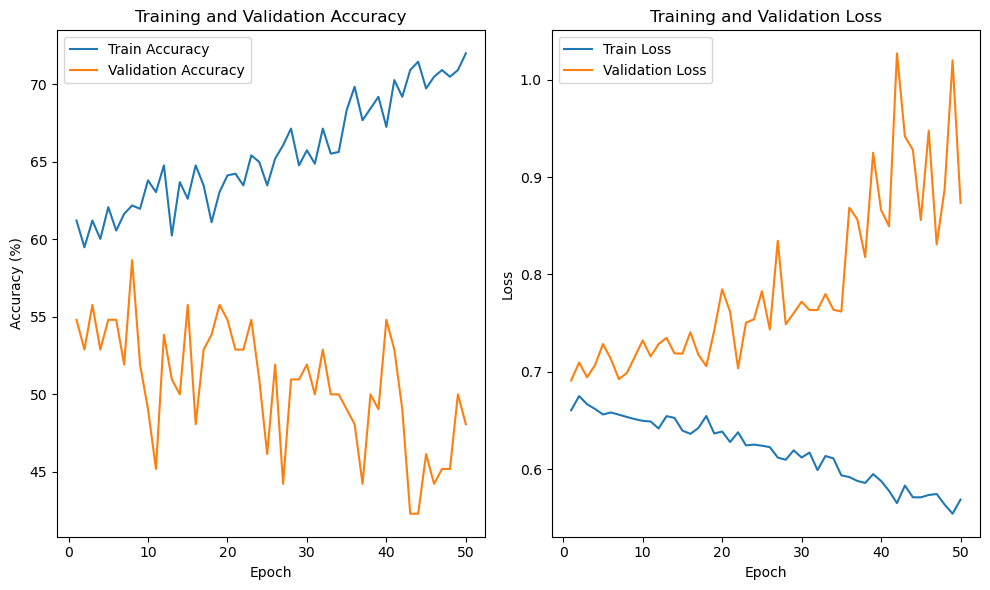

In [34]:
import matplotlib.pyplot as plt

# 손실 기록을 저장할 리스트 초기화
train_losses = []
validation_losses = []

# 정확도 기록을 저장할 리스트 초기화 (이전 코드에서 사용한 것과 동일)
train_accuracies = []
validation_accuracies = []

num_epochs = 50

# 훈련 및 검증 루프
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    # train 및 validate 함수가 손실과 정확도를 모두 반환하도록 수정해야 합니다.
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc,val_f1 = validate(model, test_loader, criterion, device)
    
    # 손실 기록
    train_losses.append(train_loss)
    validation_losses.append(val_loss)
    
    # 정확도 기록
    train_accuracies.append(train_acc)
    validation_accuracies.append(val_acc)

# 정확도 그래프 시각화
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)  # 1행 2열의 첫 번째 subplot
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

# 손실 그래프 시각화
plt.subplot(1, 2, 2)  # 1행 2열의 두 번째 subplot
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


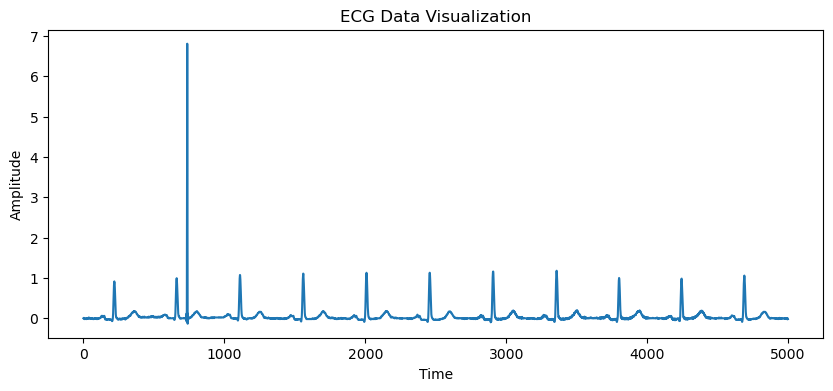

In [169]:
import wfdb
import matplotlib.pyplot as plt

# 데이터 파일 경로
data_path = 'C:\\Users\\psjj\\24w_MI_Multimodal_Prediction\\processed_data\\ecg_data\\MI_NOT_M_ecg\\p1169\\p11696880\\40369619'

# 데이터 로드
record = wfdb.rdrecord(data_path)

# 첫 번째 채널의 데이터를 선택 (ECG 데이터의 경우 여러 채널이 있을 수 있습니다)
ecg_data = record.p_signal[:, 0]

# 시각화
plt.figure(figsize=(10, 4))
plt.plot(ecg_data)
plt.title('ECG Data Visualization')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.show()
